In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
output_dir = config['output_dir']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

In [4]:
stimulus_name = 'natural_movies'  # 'natural_movie_one', 'natural_movie_three'

### Get heatmap data from session and probe

In [5]:
session_list = set()
for f in os.listdir(output_dir):
    if f.startswith('session'):
        f_strs = os.path.splitext(f)[0].split('_')
        if len(f_strs) > 2 and f_strs[2] == ecephys_structure_acronym:
            if os.path.isdir(os.path.join(output_dir, '_'.join(f_strs[:2]))):
                session_list.add(int(f_strs[1]))
session_list = list(session_list)

In [6]:
power_ds = {}
for session_id in session_list:
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
    try:
        with open(info_file) as f:
            info = json.load(f)
        probe_id = info['probe_id']
        probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
        heatmap_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}_power_heatmap.nc')
        pow_ds = xr.load_dataset(heatmap_file)
        pow_ds.load()
    except Exception as e:
        print(e)
        continue
    power_ds[session_id] = pow_ds

### Plot heatmaps

In [7]:
figsize = (6, 5)

In [8]:
# for session_id, ds in power_ds.items():
#     print(f"Session {session_id:d}")
#     coords = ds.coords
#     wave = coords['wave']
#     n_waves = wave.size
#     x_bins, y_bins = coords['x_edge'].values, coords['y_edge'].values
#     fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
#     for i, w in enumerate(wave.values):
#         ax = axs[i]
#         pcm = heatmap_in_grid(ds.power.sel(wave=w).values, x_bins, y_bins,
#             xticks_fmt=ds.attrs['xticks_fmt'], yticks_fmt=ds.attrs['yticks_fmt'],
#             even_grid=True, ax=ax)
#         plt.colorbar(mappable=pcm, ax=ax, label=ds.attrs['power_metric'], pad=0.02)
#         ax.set_xlabel(ds.attrs['xlabel'])
#         ax.set_ylabel(ds.attrs['ylabel'])
#         ax.set_title(w)
#     plt.tight_layout()
# plt.show()

### Compile data from all sessions

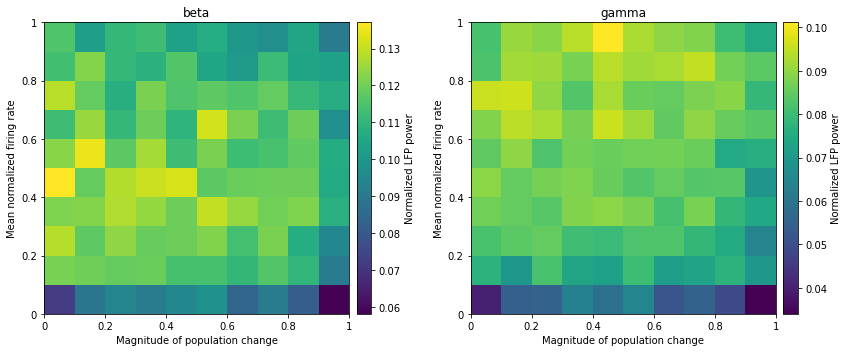

In [20]:
nticks = 6

avg_pow = xr.concat([ds.power for ds in power_ds.values()], dim=pd.Index(power_ds, name='session'))
avg_pow = avg_pow.mean(dim='session').assign_attrs(next(iter(power_ds.values())).attrs)

coords = avg_pow.coords
wave = coords['wave']
n_waves = wave.size
n_bins = coords['x_bin'].size, coords['y_bin'].size
x_bins = np.linspace(0., 1., n_bins[0] + 1)
y_bins = np.linspace(0., 1., n_bins[1] + 1)

fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
for ax, w in zip(axs, wave.values):
    pcm = heatmap_in_grid(avg_pow.sel(wave=w).values, x_bins, y_bins,
        xticks_fmt='{:g}', yticks_fmt='{:g}', even_grid=True, ax=ax)
    ax.get_xaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
    ax.get_yaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
    plt.colorbar(mappable=pcm, ax=ax, label=avg_pow.attrs['power_metric'], pad=0.02)
    ax.set_xlabel(avg_pow.attrs['xlabel'])
    ax.set_ylabel(avg_pow.attrs['ylabel'])
    ax.set_title(w)
plt.tight_layout()
plt.show()